# Fire Evacuation Planning for the MI Building

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

from vae_utils import *

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F




# define a VAE
class VAE(nn.Module):
    def __init__(self, in_features=784, intermediate_dim=256, latent_dim=2):
        super(VAE, self).__init__()

        self.in_features = in_features
        self.latent_dim = latent_dim
        # encoder
        self.enc1 = nn.Linear(in_features=in_features, out_features=intermediate_dim)
        self.enc2 = nn.Linear(in_features=intermediate_dim, out_features=intermediate_dim)
        self.enc3 = nn.Linear(in_features=intermediate_dim, out_features=intermediate_dim)
        self.enc4 = nn.Linear(in_features=intermediate_dim, out_features=intermediate_dim)
        self.enc_out = nn.Linear(in_features=intermediate_dim, out_features=latent_dim + latent_dim)

        # decoder
        self.dec1 = nn.Linear(in_features=latent_dim, out_features=intermediate_dim)
        self.dec2 = nn.Linear(in_features=intermediate_dim, out_features=intermediate_dim)
        self.dec3 = nn.Linear(in_features=intermediate_dim, out_features=intermediate_dim)
        self.dec4 = nn.Linear(in_features=intermediate_dim, out_features=intermediate_dim)
        self.dec_out = nn.Linear(in_features=intermediate_dim, out_features=in_features)

        self.log_var_rec = nn.Parameter(torch.tensor(1.))

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)  # sampling as if coming from the input space
        return sample

    def forward(self, x):
        # encoding
        mu_latent, log_var_latent = self.encode(x)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu_latent, log_var_latent)
        # decoding
        mu_rec = self.decode(z)
        return mu_rec, mu_latent, log_var_latent

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc_out(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu_latent = x[:, 0, :]  # the first feature values as mean
        log_var_latent = x[:, 1, :]  # the other feature values as variance
        return mu_latent, log_var_latent

    def decode(self, z):
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        mu_rec = self.dec_out(x)
        return mu_rec

    def generate_many(self, num_samples=15):
        z = torch.randn(num_samples, self.latent_dim)
        mu_rec = torch.zeros(num_samples, self.in_features)
        # decoding num_samples time
        for i in range(z.shape[0]):
            mu_rec[i] = self.decode(z[i])
        return mu_rec




In [3]:
train_set = np.load("../data/FireEvac_train_set.npy")
test_set = np.load("../data/FireEvac_test_set.npy")
train_set.shape, test_set.shape

((3000, 2), (600, 2))

Scatter plot train and test data

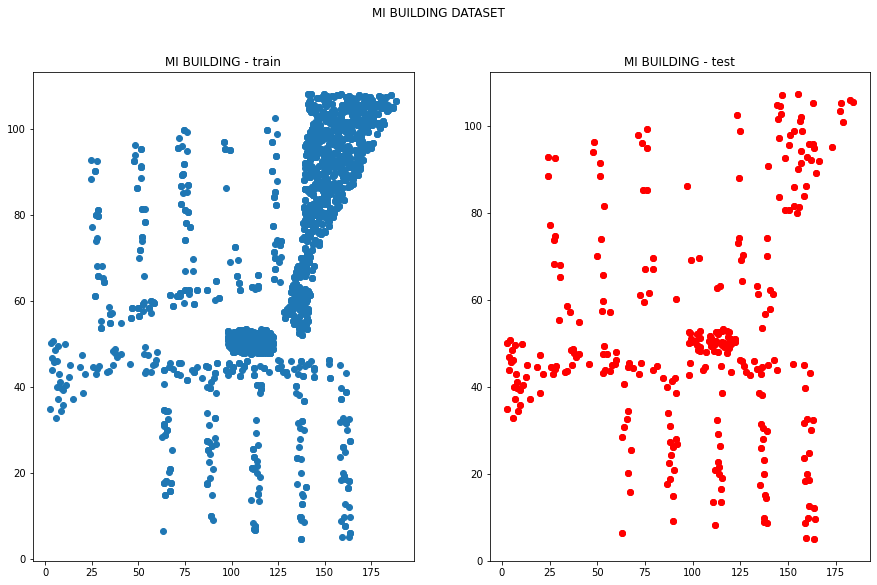

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,9))
fig.suptitle("MI BUILDING DATASET")
ax[0].scatter(train_set[:,0], train_set[:,1])
ax[0].set_title("MI BUILDING - train")
ax[1].scatter(test_set[:,0], test_set[:,1], c='red')
ax[1].set_title("MI BUILDING - test")
plt.show()

Scale between -1 and 1

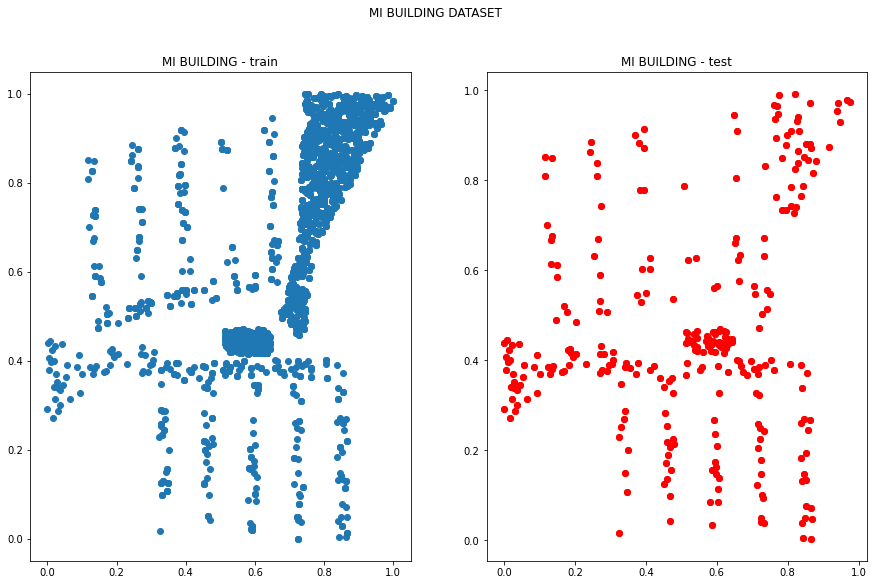

In [5]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
train_set = minmax_scaler.fit_transform(train_set)
test_set = minmax_scaler.transform(test_set)

fig, ax = plt.subplots(1,2, figsize=(15,9))
fig.suptitle("MI BUILDING DATASET")
ax[0].scatter(train_set[:,0], train_set[:,1])
ax[0].set_title("MI BUILDING - train")
ax[1].scatter(test_set[:,0], test_set[:,1], c='red')
ax[1].set_title("MI BUILDING - test")
plt.show()

Train a VAE model on the train data of MI Building

In [6]:
# set learning parameters
epochs = 165
batch_size = 128
lr = 0.001

# prepare model and optimizer
model = VAE(in_features=2, latent_dim=32, intermediate_dim=256)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
# prepare dataloaders for both data, useful in pytorch
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [8]:
def fit(model, dataloader, optimizer, train_data, epoch=None, labelled=True):
    model.train()
    running_loss = 0.0
    reconstruction = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data = data[0] if labelled else data
        data = data.view(data.size(0), -1)
        data = data.float()
        optimizer.zero_grad()
        mu_rec, mu_latent, logvar_latent = model(data)
        reconstruction.append(mu_rec)
        loss = elbo_loss(mu_rec, model.log_var_rec, mu_latent, logvar_latent, data)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss, reconstruction

def test(model, dataloader, test_data, epoch=None):
    model.eval()
    running_loss = 0.0
    reconstruction = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_data) / dataloader.batch_size)):
            data = data.view(data.size(0), -1)
            data = data.float()
            mu_rec, mu_latent, logvar_latent = model(data)
            reconstruction.append(mu_rec)
            loss = elbo_loss(mu_rec, model.log_var_rec, mu_latent, logvar_latent, data)
            running_loss += loss.item()
    test_loss = running_loss / len(dataloader.dataset)
    for batch in reconstruction:
        batch.requires_grad=False
    return test_loss, reconstruction

def plot_loss(train_loss=None, test_loss=None, epochs=None):
    if train_loss is not None:
        x = train_loss
        plt.plot(x, label='train_loss', c='blue')
    if test_loss is not None:
        x = test_loss
        plt.plot(x, label='test_loss', c='red', linestyle='dashed')
    plt.title("ELBO LOSS PLOT")
    plt.legend()
    plt.show()

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [00:00<00:00, 94.69it/s]

Epoch 1 of 165


24it [00:00, 100.42it/s]                                                                                               
5it [00:00, 500.01it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 114.29it/s]

Train Loss: 5.7067
Test Loss: 5.6660
Epoch 2 of 165


24it [00:00, 102.13it/s]                                                                                               
5it [00:00, 416.72it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 103.77it/s]

Train Loss: 5.6263
Test Loss: 5.6278
Epoch 3 of 165


24it [00:00, 104.80it/s]                                                                                               
5it [00:00, 333.23it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 112.15it/s]

Train Loss: 5.5781
Test Loss: 5.5741
Epoch 4 of 165


24it [00:00, 112.15it/s]                                                                                               
5it [00:00, 384.71it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 107.85it/s]

Train Loss: 5.5303
Test Loss: 5.5230
Epoch 5 of 165


24it [00:00, 112.15it/s]                                                                                               
5it [00:00, 416.66it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 102.80it/s]

Train Loss: 5.4823
Test Loss: 5.4733
Epoch 6 of 165


24it [00:00, 99.17it/s]                                                                                                
5it [00:00, 416.56it/s]                                                                                                
 43%|███████████████████████████████████▋                                              | 10/23 [00:00<00:00, 98.04it/s]

Train Loss: 5.4357
Test Loss: 5.4344
Epoch 7 of 165


24it [00:00, 104.80it/s]                                                                                               
5it [00:00, 312.51it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 115.39it/s]

Train Loss: 5.3889
Test Loss: 5.3763
Epoch 8 of 165


24it [00:00, 109.59it/s]                                                                                               
5it [00:00, 500.01it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 108.91it/s]

Train Loss: 5.3415
Test Loss: 5.3450
Epoch 9 of 165


24it [00:00, 107.14it/s]                                                                                               
5it [00:00, 555.77it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 105.77it/s]

Train Loss: 5.2937
Test Loss: 5.2945
Epoch 10 of 165


24it [00:00, 100.42it/s]                                                                                               
5it [00:00, 357.13it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 114.28it/s]

Train Loss: 5.2459
Test Loss: 5.2447
Epoch 11 of 165


24it [00:00, 110.60it/s]                                                                                               
5it [00:00, 333.32it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 112.15it/s]

Train Loss: 5.1988
Test Loss: 5.1937
Epoch 12 of 165


24it [00:00, 102.56it/s]                                                                                               
5it [00:00, 416.70it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 118.81it/s]

Train Loss: 5.1519
Test Loss: 5.1577
Epoch 13 of 165


24it [00:00, 103.45it/s]                                                                                               
5it [00:00, 500.07it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 108.91it/s]

Train Loss: 5.1047
Test Loss: 5.1064
Epoch 14 of 165


24it [00:00, 106.19it/s]                                                                                               
5it [00:00, 499.91it/s]                                                                                                
 57%|█████████████████████████████████████████████▊                                   | 13/23 [00:00<00:00, 120.37it/s]

Train Loss: 5.0572
Test Loss: 5.0577
Epoch 15 of 165


24it [00:00, 118.81it/s]                                                                                               
5it [00:00, 357.24it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 118.81it/s]

Train Loss: 5.0106
Test Loss: 5.0048
Epoch 16 of 165


24it [00:00, 112.68it/s]                                                                                               
5it [00:00, 555.61it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 116.51it/s]

Train Loss: 4.9629
Test Loss: 4.9705
Epoch 17 of 165


24it [00:00, 115.39it/s]                                                                                               
5it [00:00, 357.24it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 115.39it/s]

Train Loss: 4.9158
Test Loss: 4.9213
Epoch 18 of 165


24it [00:00, 107.61it/s]                                                                                               
5it [00:00, 416.54it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 116.51it/s]

Train Loss: 4.8691
Test Loss: 4.8926
Epoch 19 of 165


24it [00:00, 117.07it/s]                                                                                               
5it [00:00, 454.64it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 117.65it/s]

Train Loss: 4.8226
Test Loss: 4.8225
Epoch 20 of 165


24it [00:00, 106.65it/s]                                                                                               
5it [00:00, 356.73it/s]                                                                                                
 57%|█████████████████████████████████████████████▊                                   | 13/23 [00:00<00:00, 118.18it/s]

Train Loss: 4.7745
Test Loss: 4.7816
Epoch 21 of 165


24it [00:00, 111.11it/s]                                                                                               
5it [00:00, 454.49it/s]                                                                                                
 57%|█████████████████████████████████████████████▊                                   | 13/23 [00:00<00:00, 120.37it/s]

Train Loss: 4.7277
Test Loss: 4.7254
Epoch 22 of 165


24it [00:00, 113.75it/s]                                                                                               
5it [00:00, 454.62it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 116.51it/s]

Train Loss: 4.6812
Test Loss: 4.6976
Epoch 23 of 165


24it [00:00, 116.50it/s]                                                                                               
5it [00:00, 416.58it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 116.46it/s]

Train Loss: 4.6339
Test Loss: 4.6414
Epoch 24 of 165


24it [00:00, 112.67it/s]                                                                                               
5it [00:00, 416.65it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 106.80it/s]

Train Loss: 4.5868
Test Loss: 4.5965
Epoch 25 of 165


24it [00:00, 104.80it/s]                                                                                               
5it [00:00, 384.63it/s]                                                                                                
 52%|██████████████████████████████████████████▎                                      | 12/23 [00:00<00:00, 117.65it/s]

Train Loss: 4.5400
Test Loss: 4.5622
Epoch 26 of 165


24it [00:00, 115.39it/s]                                                                                               
5it [00:00, 499.96it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 106.79it/s]

Train Loss: 4.4933
Test Loss: 4.5049
Epoch 27 of 165


24it [00:00, 105.73it/s]                                                                                               
5it [00:00, 499.98it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 102.81it/s]

Train Loss: 4.4464
Test Loss: 4.4592
Epoch 28 of 165


24it [00:00, 98.77it/s]                                                                                                
5it [00:00, 332.61it/s]                                                                                                
 48%|██████████████████████████████████████▋                                          | 11/23 [00:00<00:00, 107.81it/s]

Train Loss: 4.3994
Test Loss: 4.4138
Epoch 29 of 165


24it [00:00, 97.17it/s]                                                                                                
5it [00:00, 500.05it/s]                                                                                                
 43%|███████████████████████████████████▋                                              | 10/23 [00:00<00:00, 95.24it/s]

Train Loss: 4.3528
Test Loss: 4.3584
Epoch 30 of 165


24it [00:00, 91.60it/s]                                                                                                
5it [00:00, 333.28it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 78.95it/s]

Train Loss: 4.3061
Test Loss: 4.3223
Epoch 31 of 165


24it [00:00, 80.27it/s]                                                                                                
5it [00:00, 416.64it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 85.71it/s]

Train Loss: 4.2595
Test Loss: 4.2682
Epoch 32 of 165


24it [00:00, 83.62it/s]                                                                                                
5it [00:00, 384.55it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 83.33it/s]

Train Loss: 4.2128
Test Loss: 4.2135
Epoch 33 of 165


24it [00:00, 76.68it/s]                                                                                                
5it [00:00, 416.56it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 75.47it/s]

Train Loss: 4.1667
Test Loss: 4.1924
Epoch 34 of 165


24it [00:00, 75.95it/s]                                                                                                
5it [00:00, 357.18it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 79.21it/s]

Train Loss: 4.1199
Test Loss: 4.1452
Epoch 35 of 165


24it [00:00, 79.74it/s]                                                                                                
5it [00:00, 499.99it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 76.92it/s]

Train Loss: 4.0731
Test Loss: 4.0897
Epoch 36 of 165


24it [00:00, 78.18it/s]                                                                                                
5it [00:00, 454.49it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 85.72it/s]

Train Loss: 4.0266
Test Loss: 4.0459
Epoch 37 of 165


24it [00:00, 74.30it/s]                                                                                                
5it [00:00, 453.10it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 76.92it/s]

Train Loss: 3.9801
Test Loss: 3.9995
Epoch 38 of 165


24it [00:00, 81.36it/s]                                                                                                
5it [00:00, 333.36it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 83.30it/s]

Train Loss: 3.9336
Test Loss: 3.9664
Epoch 39 of 165


24it [00:00, 83.92it/s]                                                                                                
5it [00:00, 384.70it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 87.38it/s]

Train Loss: 3.8873
Test Loss: 3.9096
Epoch 40 of 165


24it [00:00, 82.47it/s]                                                                                                
5it [00:00, 454.54it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 80.00it/s]

Train Loss: 3.8409
Test Loss: 3.8716
Epoch 41 of 165


24it [00:00, 75.24it/s]                                                                                                
5it [00:00, 454.52it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 76.19it/s]

Train Loss: 3.7943
Test Loss: 3.8199
Epoch 42 of 165


24it [00:00, 67.23it/s]                                                                                                
5it [00:00, 499.99it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 76.93it/s]

Train Loss: 3.7482
Test Loss: 3.7712
Epoch 43 of 165


24it [00:00, 72.73it/s]                                                                                                
5it [00:00, 454.57it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 70.80it/s]

Train Loss: 3.7028
Test Loss: 3.7280
Epoch 44 of 165


24it [00:00, 75.23it/s]                                                                                                
5it [00:00, 415.60it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 72.73it/s]

Train Loss: 3.6557
Test Loss: 3.6866
Epoch 45 of 165


24it [00:00, 73.62it/s]                                                                                                
5it [00:00, 357.15it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 81.82it/s]

Train Loss: 3.6097
Test Loss: 3.6457
Epoch 46 of 165


24it [00:00, 79.73it/s]                                                                                                
5it [00:00, 332.63it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 64.22it/s]

Train Loss: 3.5634
Test Loss: 3.5989
Epoch 47 of 165


24it [00:00, 76.68it/s]                                                                                                
5it [00:00, 454.62it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 74.08it/s]

Train Loss: 3.5172
Test Loss: 3.5529
Epoch 48 of 165


24it [00:00, 77.17it/s]                                                                                                
5it [00:00, 416.61it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 70.80it/s]

Train Loss: 3.4718
Test Loss: 3.5403
Epoch 49 of 165


24it [00:00, 69.16it/s]                                                                                                
5it [00:00, 455.60it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 70.18it/s]

Train Loss: 3.4265
Test Loss: 3.4829
Epoch 50 of 165


24it [00:00, 75.47it/s]                                                                                                
5it [00:00, 312.51it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.06it/s]

Train Loss: 3.3799
Test Loss: 3.4304
Epoch 51 of 165


24it [00:00, 67.04it/s]                                                                                                
5it [00:00, 499.83it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 70.18it/s]

Train Loss: 3.3334
Test Loss: 3.3597
Epoch 52 of 165


24it [00:00, 70.38it/s]                                                                                                
5it [00:00, 416.83it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 57.69it/s]

Train Loss: 3.2879
Test Loss: 3.3262
Epoch 53 of 165


24it [00:00, 62.83it/s]                                                                                                
5it [00:00, 454.52it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 69.29it/s]

Train Loss: 3.2416
Test Loss: 3.2771
Epoch 54 of 165


24it [00:00, 71.43it/s]                                                                                                
5it [00:00, 454.55it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 72.73it/s]

Train Loss: 3.1960
Test Loss: 3.2444
Epoch 55 of 165


24it [00:00, 71.64it/s]                                                                                                
5it [00:00, 499.89it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 79.21it/s]

Train Loss: 3.1509
Test Loss: 3.1829
Epoch 56 of 165


24it [00:00, 74.30it/s]                                                                                                
5it [00:00, 416.71it/s]                                                                                                
 70%|█████████████████████████████████████████████████████████                         | 16/23 [00:00<00:00, 76.63it/s]

Train Loss: 3.1049
Test Loss: 3.1487
Epoch 57 of 165


24it [00:00, 76.92it/s]                                                                                                
5it [00:00, 383.52it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 72.05it/s]

Train Loss: 3.0592
Test Loss: 3.1231
Epoch 58 of 165


24it [00:00, 75.00it/s]                                                                                                
5it [00:00, 454.41it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 75.47it/s]

Train Loss: 3.0134
Test Loss: 3.0536
Epoch 59 of 165


24it [00:00, 76.68it/s]                                                                                                
5it [00:00, 185.20it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 68.63it/s]

Train Loss: 2.9679
Test Loss: 3.0250
Epoch 60 of 165


24it [00:00, 71.86it/s]                                                                                                
5it [00:00, 312.51it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 71.43it/s]

Train Loss: 2.9226
Test Loss: 2.9700
Epoch 61 of 165


24it [00:00, 67.04it/s]                                                                                                
5it [00:00, 312.03it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 68.63it/s]

Train Loss: 2.8772
Test Loss: 2.9185
Epoch 62 of 165


24it [00:00, 66.67it/s]                                                                                                
5it [00:00, 416.60it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 76.92it/s]

Train Loss: 2.8325
Test Loss: 2.8969
Epoch 63 of 165


24it [00:00, 74.07it/s]                                                                                                
5it [00:00, 454.57it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 79.21it/s]

Train Loss: 2.7866
Test Loss: 2.8646
Epoch 64 of 165


24it [00:00, 78.17it/s]                                                                                                
5it [00:00, 357.07it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 74.77it/s]

Train Loss: 2.7416
Test Loss: 2.7987
Epoch 65 of 165


24it [00:00, 73.62it/s]                                                                                                
5it [00:00, 416.65it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.64it/s]

Train Loss: 2.6965
Test Loss: 2.7462
Epoch 66 of 165


24it [00:00, 64.34it/s]                                                                                                
5it [00:00, 499.92it/s]                                                                                                
 39%|████████████████████████████████▍                                                  | 9/23 [00:00<00:00, 81.82it/s]

Train Loss: 2.6513
Test Loss: 2.7148
Epoch 67 of 165


24it [00:00, 74.53it/s]                                                                                                
5it [00:00, 454.61it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 73.37it/s]

Train Loss: 2.6066
Test Loss: 2.6668
Epoch 68 of 165


24it [00:00, 75.47it/s]                                                                                                
5it [00:00, 416.61it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 75.47it/s]

Train Loss: 2.5609
Test Loss: 2.6432
Epoch 69 of 165


24it [00:00, 74.30it/s]                                                                                                
5it [00:00, 498.05it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 57.15it/s]

Train Loss: 2.5160
Test Loss: 2.5909
Epoch 70 of 165


24it [00:00, 68.57it/s]                                                                                                
5it [00:00, 499.96it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 75.47it/s]

Train Loss: 2.4714
Test Loss: 2.5292
Epoch 71 of 165


24it [00:00, 72.73it/s]                                                                                                
5it [00:00, 384.73it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 76.94it/s]

Train Loss: 2.4274
Test Loss: 2.4906
Epoch 72 of 165


24it [00:00, 75.24it/s]                                                                                                
5it [00:00, 500.24it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.50it/s]

Train Loss: 2.3826
Test Loss: 2.4520
Epoch 73 of 165


24it [00:00, 63.32it/s]                                                                                                
5it [00:00, 312.52it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.48it/s]

Train Loss: 2.3374
Test Loss: 2.4491
Epoch 74 of 165


24it [00:00, 63.49it/s]                                                                                                
5it [00:00, 416.66it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 70.80it/s]

Train Loss: 2.2932
Test Loss: 2.3784
Epoch 75 of 165


24it [00:00, 66.67it/s]                                                                                                
5it [00:00, 384.60it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 69.31it/s]

Train Loss: 2.2488
Test Loss: 2.3334
Epoch 76 of 165


24it [00:00, 66.85it/s]                                                                                                
5it [00:00, 500.05it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 74.07it/s]

Train Loss: 2.2043
Test Loss: 2.2911
Epoch 77 of 165


24it [00:00, 69.36it/s]                                                                                                
5it [00:00, 500.01it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 72.73it/s]

Train Loss: 2.1618
Test Loss: 2.2568
Epoch 78 of 165


24it [00:00, 68.18it/s]                                                                                                
5it [00:00, 293.84it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 73.39it/s]

Train Loss: 2.1164
Test Loss: 2.1848
Epoch 79 of 165


24it [00:00, 66.30it/s]                                                                                                
5it [00:00, 499.95it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 71.43it/s]

Train Loss: 2.0725
Test Loss: 2.1260
Epoch 80 of 165


24it [00:00, 65.93it/s]                                                                                                
5it [00:00, 454.59it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 2.0307
Test Loss: 2.1167
Epoch 81 of 165


24it [00:00, 67.23it/s]                                                                                                
5it [00:00, 333.33it/s]                                                                                                
 35%|████████████████████████████▊                                                      | 8/23 [00:00<00:00, 72.07it/s]

Train Loss: 1.9844
Test Loss: 2.1187
Epoch 82 of 165


24it [00:00, 69.97it/s]                                                                                                
5it [00:00, 416.61it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.64it/s]

Train Loss: 1.9410
Test Loss: 2.0643
Epoch 83 of 165


24it [00:00, 67.04it/s]                                                                                                
5it [00:00, 312.53it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 53.57it/s]

Train Loss: 1.8980
Test Loss: 2.0085
Epoch 84 of 165


24it [00:00, 60.61it/s]                                                                                                
5it [00:00, 311.81it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: 1.8531
Test Loss: 1.9621
Epoch 85 of 165


24it [00:00, 63.83it/s]                                                                                                
5it [00:00, 416.70it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 61.40it/s]

Train Loss: 1.8092
Test Loss: 1.9599
Epoch 86 of 165


24it [00:00, 61.38it/s]                                                                                                
5it [00:00, 454.56it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.67it/s]

Train Loss: 1.7671
Test Loss: 1.9084
Epoch 87 of 165


24it [00:00, 65.57it/s]                                                                                                
5it [00:00, 356.99it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 68.63it/s]

Train Loss: 1.7234
Test Loss: 1.8422
Epoch 88 of 165


24it [00:00, 67.42it/s]                                                                                                
5it [00:00, 416.71it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.64it/s]

Train Loss: 1.6792
Test Loss: 1.8177
Epoch 89 of 165


24it [00:00, 64.00it/s]                                                                                                
5it [00:00, 333.37it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 60.87it/s]

Train Loss: 1.6367
Test Loss: 1.8168
Epoch 90 of 165


24it [00:00, 63.66it/s]                                                                                                
5it [00:00, 333.29it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 1.5940
Test Loss: 1.7422
Epoch 91 of 165


24it [00:00, 65.04it/s]                                                                                                
5it [00:00, 454.55it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 67.31it/s]

Train Loss: 1.5510
Test Loss: 1.6972
Epoch 92 of 165


24it [00:00, 64.00it/s]                                                                                                
5it [00:00, 312.45it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 67.96it/s]

Train Loss: 1.5084
Test Loss: 1.6670
Epoch 93 of 165


24it [00:00, 65.57it/s]                                                                                                
5it [00:00, 453.21it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 53.10it/s]

Train Loss: 1.4654
Test Loss: 1.6057
Epoch 94 of 165


24it [00:00, 60.00it/s]                                                                                                
5it [00:00, 416.66it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 67.31it/s]

Train Loss: 1.4221
Test Loss: 1.6180
Epoch 95 of 165


24it [00:00, 64.00it/s]                                                                                                
5it [00:00, 384.54it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 67.31it/s]

Train Loss: 1.3798
Test Loss: 1.5157
Epoch 96 of 165


24it [00:00, 63.66it/s]                                                                                                
5it [00:00, 454.40it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.50it/s]

Train Loss: 1.3392
Test Loss: 1.4851
Epoch 97 of 165


24it [00:00, 62.02it/s]                                                                                                
5it [00:00, 312.48it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 1.2972
Test Loss: 1.5146
Epoch 98 of 165


24it [00:00, 62.83it/s]                                                                                                
5it [00:00, 294.11it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.50it/s]

Train Loss: 1.2543
Test Loss: 1.4185
Epoch 99 of 165


24it [00:00, 61.54it/s]                                                                                                
5it [00:00, 332.60it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.50it/s]

Train Loss: 1.2122
Test Loss: 1.4439
Epoch 100 of 165


24it [00:00, 63.15it/s]                                                                                                
5it [00:00, 415.84it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 68.63it/s]

Train Loss: 1.1715
Test Loss: 1.3358
Epoch 101 of 165


24it [00:00, 59.85it/s]                                                                                                
5it [00:00, 500.02it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.07it/s]

Train Loss: 1.1291
Test Loss: 1.2584
Epoch 102 of 165


24it [00:00, 65.04it/s]                                                                                                
5it [00:00, 415.43it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 1.0898
Test Loss: 1.2578
Epoch 103 of 165


24it [00:00, 62.18it/s]                                                                                                
5it [00:00, 416.63it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 64.82it/s]

Train Loss: 1.0494
Test Loss: 1.1919
Epoch 104 of 165


24it [00:00, 66.85it/s]                                                                                                
5it [00:00, 454.56it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: 1.0064
Test Loss: 1.1736
Epoch 105 of 165


24it [00:00, 61.70it/s]                                                                                                
5it [00:00, 384.50it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.62it/s]

Train Loss: 0.9645
Test Loss: 1.1760
Epoch 106 of 165


24it [00:00, 63.16it/s]                                                                                                
5it [00:00, 499.98it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 69.31it/s]

Train Loss: 0.9231
Test Loss: 1.1303
Epoch 107 of 165


24it [00:00, 62.83it/s]                                                                                                
5it [00:00, 454.59it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 0.8838
Test Loss: 1.0646
Epoch 108 of 165


24it [00:00, 66.30it/s]                                                                                                
5it [00:00, 500.10it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 65.42it/s]

Train Loss: 0.8425
Test Loss: 1.0526
Epoch 109 of 165


24it [00:00, 61.06it/s]                                                                                                
5it [00:00, 332.57it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 64.82it/s]

Train Loss: 0.8012
Test Loss: 1.0356
Epoch 110 of 165


24it [00:00, 63.49it/s]                                                                                                
5it [00:00, 454.51it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 0.7622
Test Loss: 1.0249
Epoch 111 of 165


24it [00:00, 59.26it/s]                                                                                                
5it [00:00, 294.01it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 49.18it/s]

Train Loss: 0.7212
Test Loss: 0.9339
Epoch 112 of 165


24it [00:00, 52.29it/s]                                                                                                
5it [00:00, 312.44it/s]                                                                                                
 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 48.55it/s]

Train Loss: 0.6824
Test Loss: 0.9316
Epoch 113 of 165


24it [00:00, 52.63it/s]                                                                                                
5it [00:00, 294.12it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 50.42it/s]

Train Loss: 0.6423
Test Loss: 0.9245
Epoch 114 of 165


24it [00:00, 50.42it/s]                                                                                                
5it [00:00, 312.49it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 56.07it/s]

Train Loss: 0.6044
Test Loss: 0.8089
Epoch 115 of 165


24it [00:00, 62.50it/s]                                                                                                
5it [00:00, 500.04it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: 0.5642
Test Loss: 0.8393
Epoch 116 of 165


24it [00:00, 62.66it/s]                                                                                                
5it [00:00, 416.82it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 67.96it/s]

Train Loss: 0.5248
Test Loss: 0.8054
Epoch 117 of 165


24it [00:00, 59.55it/s]                                                                                                
5it [00:00, 333.29it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 61.95it/s]

Train Loss: 0.4853
Test Loss: 0.7308
Epoch 118 of 165


24it [00:00, 60.15it/s]                                                                                                
5it [00:00, 333.39it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 55.56it/s]

Train Loss: 0.4468
Test Loss: 0.6896
Epoch 119 of 165


24it [00:00, 62.83it/s]                                                                                                
5it [00:00, 416.61it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 65.42it/s]

Train Loss: 0.4101
Test Loss: 0.6893
Epoch 120 of 165


24it [00:00, 64.69it/s]                                                                                                
5it [00:00, 416.56it/s]                                                                                                
 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 48.55it/s]

Train Loss: 0.3760
Test Loss: 0.5544
Epoch 121 of 165


24it [00:00, 60.15it/s]                                                                                                
5it [00:00, 416.66it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 58.26it/s]

Train Loss: 0.3415
Test Loss: 0.6304
Epoch 122 of 165


24it [00:00, 62.18it/s]                                                                                                
5it [00:00, 333.29it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 65.42it/s]

Train Loss: 0.2960
Test Loss: 0.6044
Epoch 123 of 165


24it [00:00, 64.69it/s]                                                                                                
5it [00:00, 500.10it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 61.41it/s]

Train Loss: 0.2562
Test Loss: 0.6526
Epoch 124 of 165


24it [00:00, 62.66it/s]                                                                                                
5it [00:00, 455.92it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.04it/s]

Train Loss: 0.2208
Test Loss: 0.5707
Epoch 125 of 165


24it [00:00, 67.03it/s]                                                                                                
5it [00:00, 357.19it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 65.42it/s]

Train Loss: 0.1838
Test Loss: 0.4596
Epoch 126 of 165


24it [00:00, 64.17it/s]                                                                                                
5it [00:00, 416.64it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: 0.1457
Test Loss: 0.5530
Epoch 127 of 165


24it [00:00, 58.68it/s]                                                                                                
5it [00:00, 416.69it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 67.31it/s]

Train Loss: 0.1087
Test Loss: 0.5002
Epoch 128 of 165


24it [00:00, 61.22it/s]                                                                                                
5it [00:00, 454.51it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 58.84it/s]

Train Loss: 0.0709
Test Loss: 0.4540
Epoch 129 of 165


24it [00:00, 60.31it/s]                                                                                                
5it [00:00, 384.51it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 53.57it/s]

Train Loss: 0.0347
Test Loss: 0.4092
Epoch 130 of 165


24it [00:00, 58.68it/s]                                                                                                
5it [00:00, 312.26it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: -0.0020
Test Loss: 0.3981
Epoch 131 of 165


24it [00:00, 59.85it/s]                                                                                                
5it [00:00, 454.49it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 58.25it/s]

Train Loss: -0.0377
Test Loss: 0.3271
Epoch 132 of 165


24it [00:00, 59.26it/s]                                                                                                
5it [00:00, 416.75it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 53.10it/s]

Train Loss: -0.0703
Test Loss: 0.3676
Epoch 133 of 165


24it [00:00, 58.25it/s]                                                                                                
5it [00:00, 312.48it/s]                                                                                                
 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 48.55it/s]

Train Loss: -0.1070
Test Loss: 0.2996
Epoch 134 of 165


24it [00:00, 57.83it/s]                                                                                                
5it [00:00, 454.62it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: -0.1428
Test Loss: 0.2869
Epoch 135 of 165


24it [00:00, 58.68it/s]                                                                                                
5it [00:00, 416.61it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 57.14it/s]

Train Loss: -0.1782
Test Loss: 0.3271
Epoch 136 of 165


24it [00:00, 59.55it/s]                                                                                                
5it [00:00, 500.02it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 60.87it/s]

Train Loss: -0.2062
Test Loss: 0.1649
Epoch 137 of 165


24it [00:00, 57.97it/s]                                                                                                
5it [00:00, 357.12it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 60.87it/s]

Train Loss: -0.2472
Test Loss: 0.2136
Epoch 138 of 165


24it [00:00, 60.30it/s]                                                                                                
5it [00:00, 454.69it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 58.25it/s]

Train Loss: -0.2807
Test Loss: 0.2180
Epoch 139 of 165


24it [00:00, 55.56it/s]                                                                                                
5it [00:00, 454.58it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: -0.3149
Test Loss: 0.2834
Epoch 140 of 165


24it [00:00, 60.00it/s]                                                                                                
5it [00:00, 416.69it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 64.22it/s]

Train Loss: -0.3424
Test Loss: 0.1658
Epoch 141 of 165


24it [00:00, 61.07it/s]                                                                                                
5it [00:00, 454.52it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 54.05it/s]

Train Loss: -0.3800
Test Loss: 0.1346
Epoch 142 of 165


24it [00:00, 59.11it/s]                                                                                                
5it [00:00, 294.09it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 65.42it/s]

Train Loss: -0.4122
Test Loss: 0.0759
Epoch 143 of 165


24it [00:00, 61.54it/s]                                                                                                
5it [00:00, 312.56it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.64it/s]

Train Loss: -0.4468
Test Loss: 0.0805
Epoch 144 of 165


24it [00:00, 62.83it/s]                                                                                                
5it [00:00, 500.16it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 52.63it/s]

Train Loss: -0.4766
Test Loss: 0.0507
Epoch 145 of 165


24it [00:00, 57.69it/s]                                                                                                
5it [00:00, 454.69it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 54.06it/s]

Train Loss: -0.5096
Test Loss: 0.0326
Epoch 146 of 165


24it [00:00, 56.61it/s]                                                                                                
5it [00:00, 312.45it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 57.15it/s]

Train Loss: -0.5380
Test Loss: -0.0392
Epoch 147 of 165


24it [00:00, 54.67it/s]                                                                                                
5it [00:00, 277.76it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 52.63it/s]

Train Loss: -0.5686
Test Loss: 0.0210
Epoch 148 of 165


24it [00:00, 46.60it/s]                                                                                                
5it [00:00, 227.35it/s]                                                                                                
 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 44.25it/s]

Train Loss: -0.6036
Test Loss: -0.0271
Epoch 149 of 165


24it [00:00, 54.67it/s]                                                                                                
5it [00:00, 454.73it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 59.41it/s]

Train Loss: -0.6341
Test Loss: -0.0147
Epoch 150 of 165


24it [00:00, 59.85it/s]                                                                                                
5it [00:00, 384.58it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 58.25it/s]

Train Loss: -0.6642
Test Loss: -0.0995
Epoch 151 of 165


24it [00:00, 60.45it/s]                                                                                                
5it [00:00, 294.23it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 57.15it/s]

Train Loss: -0.6940
Test Loss: -0.1348
Epoch 152 of 165


24it [00:00, 56.34it/s]                                                                                                
5it [00:00, 416.64it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 61.40it/s]

Train Loss: -0.7189
Test Loss: -0.2540
Epoch 153 of 165


24it [00:00, 58.11it/s]                                                                                                
5it [00:00, 499.31it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.50it/s]

Train Loss: -0.7498
Test Loss: -0.0955
Epoch 154 of 165


24it [00:00, 60.15it/s]                                                                                                
5it [00:00, 294.12it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 63.06it/s]

Train Loss: -0.7799
Test Loss: -0.0705
Epoch 155 of 165


24it [00:00, 59.40it/s]                                                                                                
5it [00:00, 312.51it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 66.67it/s]

Train Loss: -0.8089
Test Loss: -0.2183
Epoch 156 of 165


24it [00:00, 62.02it/s]                                                                                                
5it [00:00, 312.53it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 55.55it/s]

Train Loss: -0.8373
Test Loss: -0.1620
Epoch 157 of 165


24it [00:00, 53.33it/s]                                                                                                
5it [00:00, 416.69it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 64.22it/s]

Train Loss: -0.8638
Test Loss: -0.2644
Epoch 158 of 165


24it [00:00, 58.97it/s]                                                                                                
5it [00:00, 384.64it/s]                                                                                                
 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 47.17it/s]

Train Loss: -0.8920
Test Loss: -0.1461
Epoch 159 of 165


24it [00:00, 51.50it/s]                                                                                                
5it [00:00, 294.11it/s]                                                                                                
 22%|██████████████████                                                                 | 5/23 [00:00<00:00, 45.05it/s]

Train Loss: -0.9184
Test Loss: -0.0350
Epoch 160 of 165


24it [00:00, 48.29it/s]                                                                                                
5it [00:00, 357.15it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 56.07it/s]

Train Loss: -0.9454
Test Loss: -0.2480
Epoch 161 of 165


24it [00:00, 49.38it/s]                                                                                                
5it [00:00, 416.59it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 57.14it/s]

Train Loss: -0.9731
Test Loss: -0.2107
Epoch 162 of 165


24it [00:00, 50.42it/s]                                                                                                
5it [00:00, 277.77it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 50.42it/s]

Train Loss: -0.9959
Test Loss: -0.1359
Epoch 163 of 165


24it [00:00, 51.72it/s]                                                                                                
5it [00:00, 416.67it/s]                                                                                                
 26%|█████████████████████▋                                                             | 6/23 [00:00<00:00, 56.61it/s]

Train Loss: -1.0202
Test Loss: -0.3609
Epoch 164 of 165


24it [00:00, 57.97it/s]                                                                                                
5it [00:00, 500.22it/s]                                                                                                
 30%|█████████████████████████▎                                                         | 7/23 [00:00<00:00, 62.50it/s]

Train Loss: -1.0425
Test Loss: -0.2279
Epoch 165 of 165


24it [00:00, 60.45it/s]                                                                                                
5it [00:00, 416.84it/s]                                                                                                

Train Loss: -1.0725
Test Loss: -0.4413


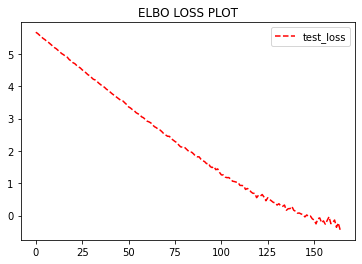

In [9]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, reconstruction_train = fit(model, train_loader, optimizer, train_set, epoch=epoch, labelled=False)
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    test_epoch_loss, reconstruction_test = test(model, test_loader, test_data=test_set, epoch=epoch)
    test_loss.append(test_epoch_loss)
    print(f"Test Loss: {test_epoch_loss:.4f}")
plot_loss(test_loss=test_loss, epochs=epochs)

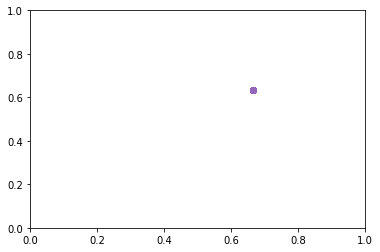

In [15]:
for batch in reconstruction_test:
    plt.scatter(batch[:,0], batch[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

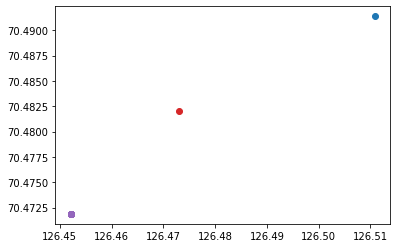

In [16]:
for batch in reconstruction_test:
    batch = minmax_scaler.inverse_transform(batch.detach())
    plt.scatter(batch[:,0], batch[:,1])
plt.show()

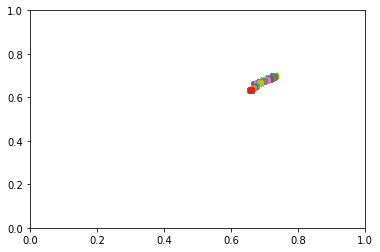

In [17]:
for batch in reconstruction_train:
    plt.scatter(batch.detach()[:,0], batch.detach()[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

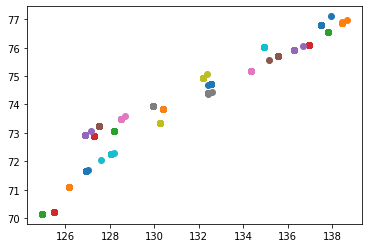

In [18]:
for batch in reconstruction_train:
    batch = minmax_scaler.inverse_transform(batch.detach())
    plt.scatter(batch[:,0], batch[:,1])
plt.show()

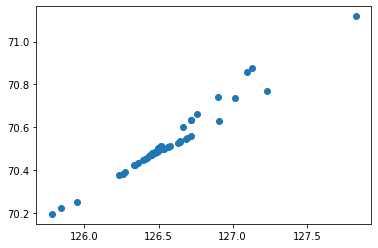

In [19]:
num_samples = 10000
mu_rec = model.generate_many(num_samples)
mu_rec = minmax_scaler.inverse_transform(mu_rec.detach())
plt.scatter(mu_rec[:,0], mu_rec[:,1])
plt.show()